In [201]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

# statistical analysis
import statsmodels.api as sm
from statsmodels import regression

import yfinance as yfin
yfin.pdr_override()

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#from var import VaR
import pandas_montecarlo

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})
#style.use('seaborn-whitegrid')
style.use("seaborn-white")
plt.rcParams["figure.figsize"] = (10,6)

# Weekly Tasks

Update your mid-course presentation with additional perspectives based on what you have learned

# Variables

In [202]:
start_date = datetime(2022, 1, 1)
purchase_date = datetime(2023, 9, 11)
purchase_date_str = '2023-9-11'
end_date = datetime.now()
end_date_str = end_date.strftime("%Y-%m-%d")

alpha = 0.05
period = '5y'

# Functions

In [203]:
def alpha(portfolio_returns, benchmark_returns):
    # mean of the return
    portfolio_avg_return = np.mean(portfolio_returns)
    benchmark_avg_return = np.mean(benchmark_returns)
    
    # volatility
    portfolio_volatility = np.std(portfolio_returns)
    benchmark_volatility = np.std(benchmark_returns)
    
    # our alpha
    alpha = (portfolio_avg_return - benchmark_avg_return) / (portfolio_volatility / benchmark_volatility)
    
    return alpha


def linreg(x,y):
    x = sm.add_constant(x) # add a column of 1s to our data (for intercept)
    model = regression.linear_model.OLS(y,x).fit()
    x = x[:, 1] # remove the constant
    return model.params[0], model.params[1]

# Load Data

## Load Variables

In [204]:
var_lst = ['GSPCX']
bench_df = pdr.get_data_yahoo(var_lst, start=purchase_date, end=end_date)['Close']
#bench_df = round((bench_df.mean() / 100),4)
bench_df = pd.DataFrame(bench_df)
bench_df.columns = ['GSPCX']

benchPercent_df = bench_df.pct_change()[1:]
benchPercent_df.reset_index(inplace=True)
benchPercent_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,GSPCX
0,2023-09-12,-0.0066
1,2023-09-13,0.0000
2,2023-09-14,0.0067
3,2023-09-15,-0.0110
4,2023-09-18,0.0000


In [205]:
var_lst = ['GSPCX']
bench_econ_df = pdr.get_data_yahoo(var_lst, start=purchase_date, end=end_date)['Close']
#bench_econ_df = round((bench_econ_df.mean() / 100),4)
bench_econ_df = pd.DataFrame(bench_econ_df)
bench_econ_df.columns = ['GSPCX']

benchPercent_econ_df = bench_econ_df.pct_change()[1:]
benchPercent_econ_df.reset_index(inplace=True)
benchPercent_econ_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,GSPCX
0,2023-09-12,-0.0066
1,2023-09-13,0.0000
2,2023-09-14,0.0067
3,2023-09-15,-0.0110
4,2023-09-18,0.0000


In [206]:
var_lst = ['AGG']
bench_int_df = pdr.get_data_yahoo(var_lst, start=purchase_date, end=end_date)['Close']
#bench_int_df = round((bench_int_df.mean() / 100),4)
bench_int_df = pd.DataFrame(bench_int_df)
bench_int_df.columns = ['AGG']

benchPercent_int_df = bench_int_df.pct_change()[1:]
benchPercent_int_df.reset_index(inplace=True)
benchPercent_int_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,AGG
0,2023-09-12,0.0003
1,2023-09-13,0.0015
2,2023-09-14,-0.0014
3,2023-09-15,-0.0023
4,2023-09-18,0.0015


## Load Porfolio

In [207]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w15/data/DATA618_Portfolio_Full.csv', 
                 parse_dates =['Date'],
                 dtype={
                    'ID': 'int',
                    'Value': 'float', 
                 })


# Class Portfolios
folio_econ_df = folio_df[folio_df['Class'] == 'Economically Sensitive']
folio_int_df = folio_df[folio_df['Class'] == 'Interest Rate Sensitive']

folio_df

,Unnamed: 0,Ticker,BondName,Morningstar_Category,Class,Sub_Class,Date,Value
0,0,IVV,iShares Core S&P 500 ETF,Large Blend,Economically Sensitive,U.S. Equities,2023-09-11,"4,000.0000"
1,1,VONG,Vanguard Russell 1000 Growth ETF,Large Growth,Economically Sensitive,U.S. Equities,2023-09-11,"3,000.0000"
2,2,SCHD,Schwab US Dividend Equity ETF™,Large Value,Economically Sensitive,U.S. Equities,2023-09-11,"3,000.0000"
3,3,IMCB,iShares Morningstar Mid-Cap ETF,Mid-Cap Blend,Economically Sensitive,U.S. Equities,2023-09-11,"4,000.0000"
4,4,VO,Vanguard Mid-Cap ETF,Mid-Cap Blend,Economically Sensitive,U.S. Equities,2023-09-11,"2,000.0000"
5,5,FSMD,Fidelity Small-Mid Multifactor ETF,Small Blend,Economically Sensitive,U.S. Equities,2023-09-11,"4,000.0000"
6,6,VBR,Vanguard Small-Cap Value ETF,Small Value,Economically Sensitive,U.S. Equities,2023-09-11,"1,000.0000"
7,7,VIGI,Vanguard Intl Div Apprec ETF,Foreign Large Growth,Economically Sensitive,International Equities,2023-09-11,"3,000.0000"
8,8,JPEM,JPMorgan Diversified Return EMkts Eq ETF,Diversified Emerging Mkts,Economically Sensitive,Emerging Market Equities,2023-09-11,"4,000.0000"
9,9,ISCF,iShares MSCI Intl Small-Cap Mltfct ETF,Foreign Small/Mid Blend,Economically Sensitive,International Equities,2023-09-11,"3,000.0000"


In [208]:
folio_df.query('Date == "2023-09-11"').groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,183.0000"
Economically Sensitive,"50,250.0000"
Interest Rate Sensitive,"29,000.0000"


In [209]:
folio_df.query('Date == "2023-09-11"')[['Value']].sum()

Value   83,433.0000
dtype: float64

## Load Shares

In [210]:
shares_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w15/data/DATA618_Shares.csv', 
                 parse_dates =['Date'])
shares_df.set_index('Date', inplace=True)
shares_df.dropna(inplace=True)
shares_df

,ALTVX,ARKK,BLUEX,BPLSX,C_A_S_H,DFAR,EXAS,FREL,FSMD,GARIX,...,TWLO,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-11,106383,0,14201,49967,4182856,108467,0,115479,120705,25278,...,0,6120,566426,54437,95923,40481,40221,9234,41501,20333
2023-09-12,106383,0,14201,49967,4182856,108467,0,115479,120705,25278,...,0,6120,566426,54437,95923,40481,40221,9234,41501,20333
2023-09-13,106383,0,14201,49967,4182856,108467,0,115479,120705,25278,...,0,6120,566426,54437,95923,40481,40221,9234,41501,20333
2023-09-14,106383,0,14201,49967,4182856,108467,0,115479,120705,25278,...,0,6120,566426,54437,95923,40481,40221,9234,41501,20333
2023-09-15,106383,0,14201,49967,4182856,108467,0,115479,120705,25278,...,0,6120,566426,54437,95923,40481,40221,9234,41501,20333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,106383,26476,14201,49967,3182856,108467,7660,115479,89079,25278,...,8996,6120,566426,54437,95923,40481,40221,9234,41501,20333
2023-12-05,106383,26476,14201,49967,3182856,108467,7660,115479,89079,25278,...,8996,6120,566426,54437,95923,40481,40221,9234,41501,20333
2023-12-06,106383,26476,14201,49967,3182856,108467,7660,115479,89079,25278,...,8996,6120,566426,54437,95923,40481,40221,9234,41501,20333


# 4. Portfolio

## 4.1 Load Pricing Time Series

In [211]:
# ticker symbols
ticker_lst = list(shares_df.columns)
print('ticker #:', len(ticker_lst))

# portfolio weights
#weight_lst = (folio_df['port_percent'].values)
#print('price #:', len(weight_lst))

#Download closing prices
price_df = pdr.get_data_yahoo(ticker_lst, start=purchase_date, end=end_date)['Close']
price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
return_df.fillna(0, inplace=True)
return_df.index = pd.to_datetime(return_df.index)
print('return_df #:', len(return_df.columns))

ticker #: 40
[*********************100%%**********************]  40 of 40 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No timezone found, symbol may be delisted')



price_df #: (64, 40)
return_df #: 40


## 4.2 Portfolio Returns

port_ret_weighted = return_df.mul(weight_lst, axis=1)
print('port_ret_weighted #:', port_ret_weighted.shape)

return_df['Portfolio'] = port_ret_weighted.sum(axis=1)
print('return_df #:', return_df.shape)

weight_lst

# 5. Calculate Portfolio Value

In [212]:
portValue_df = shares_df * price_df
portValue_df

,ALTVX,ARKK,BLUEX,BPLSX,C_A_S_H,DFAR,EXAS,FREL,FSMD,GARIX,...,TWLO,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-11,"1,000,000.1594",0.0000,"500,017.1970","750,004.6814",4182856,"2,273,468.2207",0.0000,"2,825,771.0507","4,014,648.0974","499,998.8574",...,0.0000,"1,005,393.5925","5,499,996.4816","1,000,007.7357","1,999,994.5866","3,007,333.5271","3,281,631.2427","2,007,286.9651","3,005,502.3440","999,976.9462"
2023-09-12,"998,936.4065",0.0000,"498,171.1060","748,505.6371",4182856,"2,277,807.0000",0.0000,"2,828,080.6836","4,007,406.0921","496,965.4761",...,0.0000,"1,007,474.3701","5,499,996.4816","1,000,007.7357","1,999,994.5866","2,995,998.8965","3,280,022.6727","2,003,408.7020","2,970,226.5573","999,163.6076"
2023-09-13,"998,936.4065",0.0000,"499,023.1313","746,007.3252",4182856,"2,256,113.5172",0.0000,"2,795,746.4843","3,986,886.0027","496,712.6904",...,0.0000,"1,000,191.5552","5,505,660.8713","1,001,096.3968","2,001,913.0905","2,990,736.1688","3,244,226.0073","1,992,604.7980","2,981,016.9060","999,773.5728"
2023-09-14,"997,872.5522",0.0000,"500,443.2638","753,002.6748",4182856,"2,299,500.4828",0.0000,"2,848,866.9388","4,036,375.0342","498,734.9284",...,0.0000,"1,015,002.0374","5,499,996.4816","1,001,096.3968","1,999,994.5866","3,017,858.6735","3,302,948.6305","2,012,273.2631","3,000,107.3280","998,960.3117"
2023-09-15,"997,872.5522",0.0000,"499,307.1578","750,004.6814",4182856,"2,292,992.3138",0.0000,"2,810,758.8776","3,983,265.0000","492,921.0000",...,0.0000,"1,006,801.1664","5,483,003.8529","998,918.9708","1,996,157.5788","3,012,191.3582","3,290,479.9118","1,995,005.7282","2,952,796.2133","997,333.6345"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,"1,013,829.9616","1,289,116.4036","495,472.8813","778,985.5376",3182856,"2,366,749.9069","502,955.6281","2,925,083.0612","3,058,082.2331","511,373.9284",...,"607,409.8898","1,045,112.4261","5,539,646.1287","1,018,516.2202","2,035,485.9941","3,059,554.0541","3,392,641.2886","2,046,531.4651","3,092,239.5987","1,018,886.6424"
2023-12-05,"1,015,957.6703","1,277,731.7156","492,348.6440","775,487.8629",3182856,"2,353,733.9828","496,138.1743","2,905,451.6224","3,018,887.2556","512,637.8574",...,"615,146.4553","1,030,607.9626","5,562,303.1471","1,024,504.3234","2,046,037.5827","3,046,600.1465","3,370,117.6268","2,028,802.2020","3,107,594.7660","1,021,326.5807"
2023-12-06,"1,019,149.1319","1,271,907.0642","492,064.6717","770,990.8252",3182856,"2,346,141.1190","499,125.6281","2,897,368.1276","3,018,887.2556","481,545.8807",...,"614,426.8275","1,028,833.2037","5,573,631.9264","1,027,770.5143","2,051,792.9115","3,051,862.5653","3,360,062.3768","2,026,955.2893","3,090,579.5207","1,022,343.2152"


shares_df = folio_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
shares_df.head()

m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
m_df.head()

l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)

In [213]:
m_df = portValue_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Value']
m_df.head()

,Date,Ticker,Value
0,2023-09-11,ALTVX,"1,000,000.1594"
1,2023-09-12,ALTVX,"998,936.4065"
2,2023-09-13,ALTVX,"998,936.4065"
3,2023-09-14,ALTVX,"997,872.5522"
4,2023-09-15,ALTVX,"997,872.5522"


In [214]:
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)
l_df.head()

l_df:  (40, 3)


,Ticker,Class,Sub_Class
0,IVV,Economically Sensitive,U.S. Equities
1,VONG,Economically Sensitive,U.S. Equities
2,SCHD,Economically Sensitive,U.S. Equities
3,IMCB,Economically Sensitive,U.S. Equities
4,VO,Economically Sensitive,U.S. Equities


## Ticker Weights

In [215]:
weight_df = portValue_df[-1:].T.copy()
weight_df.reset_index(inplace=True)
weight_df.columns = ['Ticker','Value']

weight_df = weight_df.merge(l_df, how='outer', left_on='Ticker', right_on='Ticker')

weight_df['port_percent'] = weight_df['Value'] / weight_df['Value'].sum()
weight_df

,Ticker,Value,Class,Sub_Class,port_percent
0,ALTVX,"1,019,149.1319",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,0.0119
1,ARKK,"1,302,089.6881",Economically Sensitive,U.S. Equities,0.0152
2,BLUEX,"494,194.7892",Economically Sensitive,Long/Short Equities,0.0058
3,BPLSX,"776,487.1781",Economically Sensitive,Long/Short Equities,0.0091
4,C_A_S_H,"3,182,856.0000",Cash,Cash,0.0373
5,DFAR,"2,348,310.5086",Economically Sensitive,Publicly Traded REITs,0.0275
6,EXAS,"495,755.2094",Economically Sensitive,U.S. Equities,0.0058
7,FREL,"2,900,832.5769",Economically Sensitive,Publicly Traded REITs,0.0340
8,FSMD,"3,050,065.1095",Economically Sensitive,U.S. Equities,0.0357
9,GARIX,"485,337.6193",Economically Sensitive,Long/Short Equities,0.0057


In [216]:
merge_df = m_df.merge(l_df, how='outer', left_on='Ticker', right_on='Ticker') #.merge(shares_df,how='outer' ,left_on='Ticker', right_on='Ticker')
#merge_df['share_value'] = merge_df['Price'] * merge_df['Shares']
merge_df['pct_share_value'] = merge_df.groupby(['Ticker'])[['Value']].pct_change()

print('merge_df: ',merge_df.shape)

merge_df:  (2560, 6)


In [217]:
merge_df

,Date,Ticker,Value,Class,Sub_Class,pct_share_value
0,2023-09-11,ALTVX,"1,000,000.1594",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,NaN
1,2023-09-12,ALTVX,"998,936.4065",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,-0.0011
2,2023-09-13,ALTVX,"998,936.4065",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,0.0000
3,2023-09-14,ALTVX,"997,872.5522",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,-0.0011
4,2023-09-15,ALTVX,"997,872.5522",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,0.0000
...,...,...,...,...,...,...
2555,2023-12-04,VTEB,"1,018,886.6424",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,-0.0008
2556,2023-12-05,VTEB,"1,021,326.5807",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,0.0024
2557,2023-12-06,VTEB,"1,022,343.2152",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,0.0010
2558,2023-12-07,VTEB,"1,022,953.2579",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,0.0006


In [218]:
m_df = merge_df[['Date','Ticker','Value']]

#m_df.reset_index(inplace=True)
#m_df = m_df.pivot(index=['Date'], columns=['Ticker'])['share_value']
m_df = m_df.pivot(index=['Date'], columns=['Ticker'])['Value']
m_df.head()

Ticker,ALTVX,ARKK,BLUEX,BPLSX,C_A_S_H,DFAR,EXAS,FREL,FSMD,GARIX,...,TWLO,VBR,VFIUX,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-11,"1,000,000.1594",0.0000,"500,017.1970","750,004.6814","4,182,856.0000","2,273,468.2207",0.0000,"2,825,771.0507","4,014,648.0974","499,998.8574",...,0.0000,"1,005,393.5925","5,499,996.4816","1,000,007.7357","1,999,994.5866","3,007,333.5271","3,281,631.2427","2,007,286.9651","3,005,502.3440","999,976.9462"
2023-09-12,"998,936.4065",0.0000,"498,171.1060","748,505.6371","4,182,856.0000","2,277,807.0000",0.0000,"2,828,080.6836","4,007,406.0921","496,965.4761",...,0.0000,"1,007,474.3701","5,499,996.4816","1,000,007.7357","1,999,994.5866","2,995,998.8965","3,280,022.6727","2,003,408.7020","2,970,226.5573","999,163.6076"
2023-09-13,"998,936.4065",0.0000,"499,023.1313","746,007.3252","4,182,856.0000","2,256,113.5172",0.0000,"2,795,746.4843","3,986,886.0027","496,712.6904",...,0.0000,"1,000,191.5552","5,505,660.8713","1,001,096.3968","2,001,913.0905","2,990,736.1688","3,244,226.0073","1,992,604.7980","2,981,016.9060","999,773.5728"
2023-09-14,"997,872.5522",0.0000,"500,443.2638","753,002.6748","4,182,856.0000","2,299,500.4828",0.0000,"2,848,866.9388","4,036,375.0342","498,734.9284",...,0.0000,"1,015,002.0374","5,499,996.4816","1,001,096.3968","1,999,994.5866","3,017,858.6735","3,302,948.6305","2,012,273.2631","3,000,107.3280","998,960.3117"
2023-09-15,"997,872.5522",0.0000,"499,307.1578","750,004.6814","4,182,856.0000","2,292,992.3138",0.0000,"2,810,758.8776","3,983,265.0000","492,921.0000",...,0.0000,"1,006,801.1664","5,483,003.8529","998,918.9708","1,996,157.5788","3,012,191.3582","3,290,479.9118","1,995,005.7282","2,952,796.2133","997,333.6345"


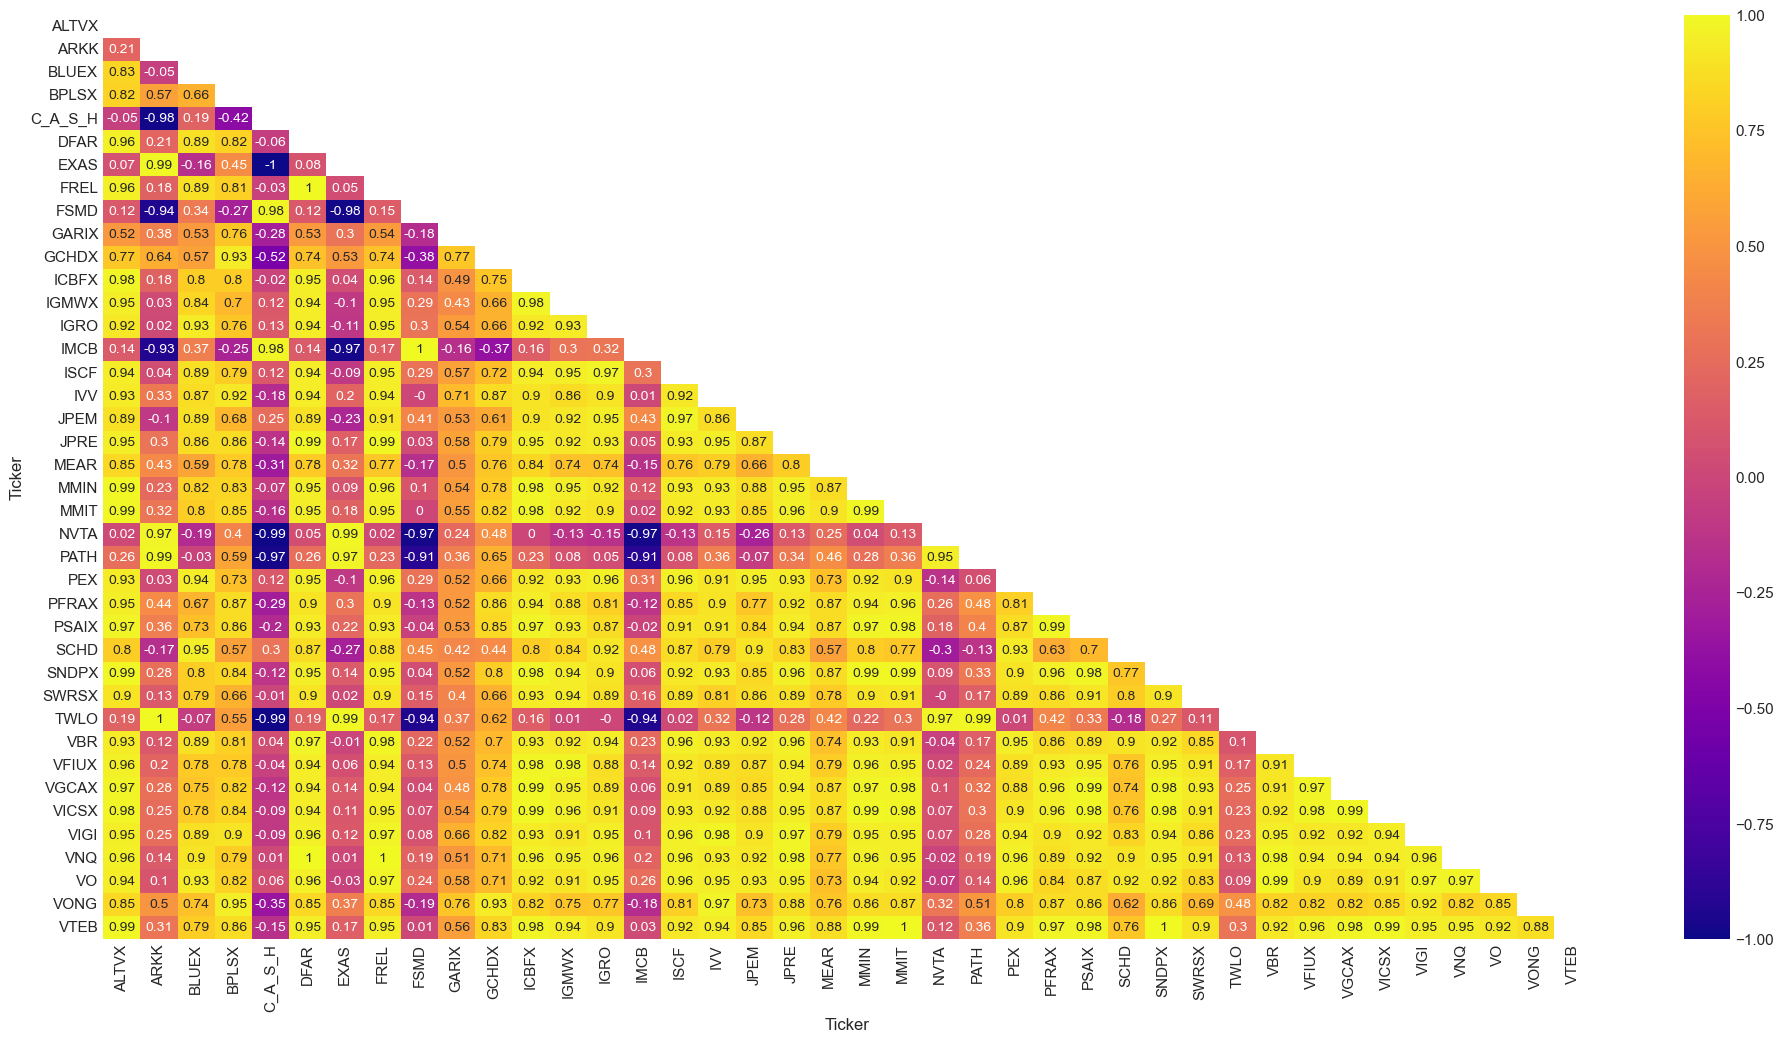

In [219]:
plt.figure(figsize=(24,12))
mask = np.zeros_like(m_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(m_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

In [220]:
totalValue_df = merge_df.groupby(['Date'])[['Value']].sum().reset_index()
totalValue_df['pct_change'] = totalValue_df['Value'].pct_change()

print('totalValue_df: ',totalValue_df.shape)

totalValue_df:  (64, 3)


In [221]:
fv_df = merge_df.groupby(['Date','Class'])[['Value']].sum().reset_index()
fv_df['pct_change'] = fv_df.groupby(['Class'])[['Value']].pct_change()

print('fv_df: ',fv_df.shape)

fv_df:  (192, 4)


## 5.1 Portfolio Value

In [222]:
totalValue_df

,Date,Value,pct_change
0,2023-09-11,"83,718,683.5760",NaN
1,2023-09-12,"83,597,204.6712",-0.0015
2,2023-09-13,"83,425,622.0770",-0.0021
3,2023-09-14,"83,951,847.4157",0.0063
4,2023-09-15,"83,535,984.2190",-0.0050
...,...,...,...
59,2023-12-04,"85,389,870.8768",-0.0011
60,2023-12-05,"85,250,624.6378",-0.0016
61,2023-12-06,"85,142,472.7031",-0.0013
62,2023-12-07,"85,333,757.6263",0.0022


folio_df.groupby(['Class','Sub_Class'])[['Value']].sum()

folio_df[['Value']].sum()

## Graph Porfolio Values

In [223]:
r1_df = totalValue_df.loc[(totalValue_df['Date'] == min(totalValue_df['Date']))
                     | (totalValue_df['Date'] == max(totalValue_df['Date']))]
print('Portfolio Return: ',r1_df['Value'].pct_change()[-1:].values)
r1_df

Portfolio Return:  [0.02032402]


,Date,Value,pct_change
0,2023-09-11,"83,718,683.5760",NaN
63,2023-12-08,"85,420,183.8826",0.0010


In [224]:
r1_df = bench_df.loc[(bench_df.index == min(bench_df.index))
                     | (bench_df.index == max(bench_df.index))]
print('Benchmark Return: ',r1_df['GSPCX'].pct_change()[-1:].values)
r1_df

Benchmark Return:  [0.02720587]


,GSPCX
Date,
2023-09-11,13.6000
2023-12-08,13.9700


In [225]:
m1_df = totalValue_df.merge(benchPercent_df, how='outer', left_on='Date', right_on='Date')
m1_df['date_str'] = m1_df['Date'].dt.strftime('%b-%d')
m1_df.head()

,Date,Value,pct_change,GSPCX,date_str
0,2023-09-11,"83,718,683.5760",NaN,NaN,Sep-11
1,2023-09-12,"83,597,204.6712",-0.0015,-0.0066,Sep-12
2,2023-09-13,"83,425,622.0770",-0.0021,0.0000,Sep-13
3,2023-09-14,"83,951,847.4157",0.0063,0.0067,Sep-14
4,2023-09-15,"83,535,984.2190",-0.0050,-0.0110,Sep-15


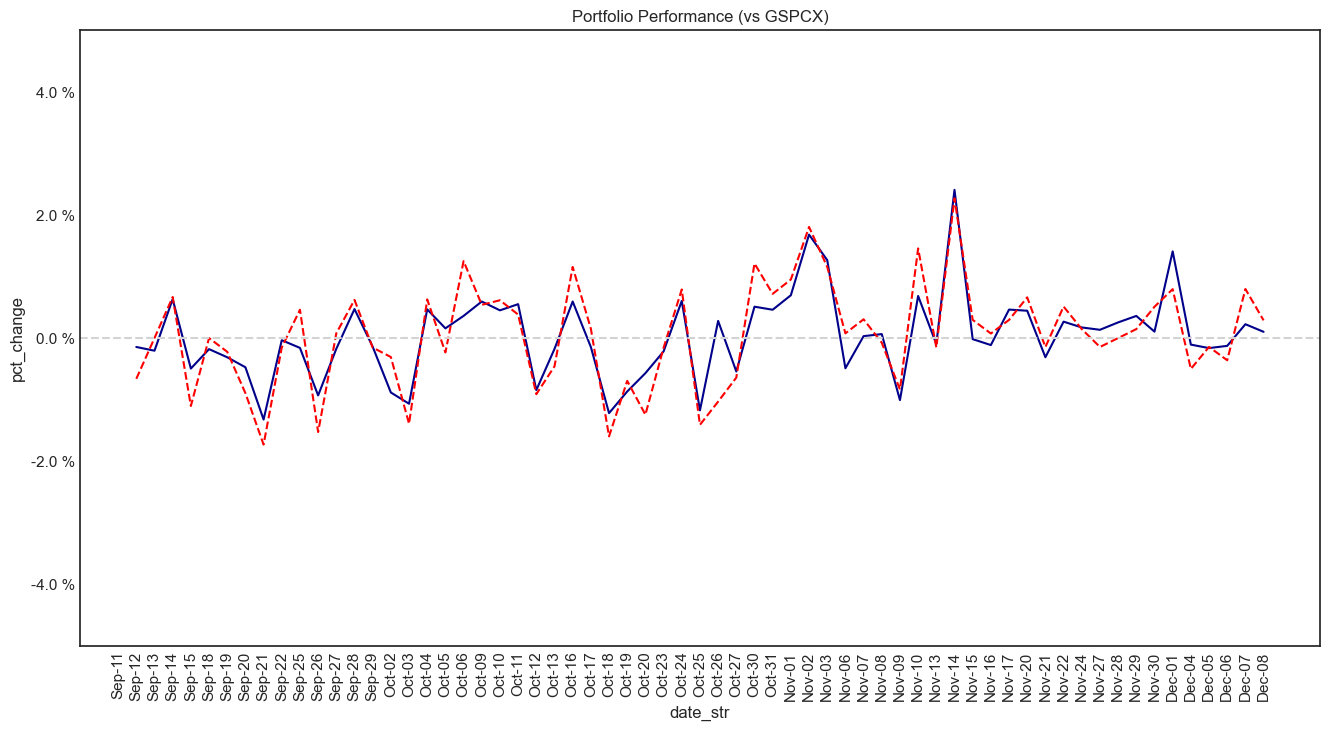

In [226]:
# Graph
fig, ax = plt.subplots(figsize=(16,8))
plt.ticklabel_format(style='plain', axis='y')

ax.set_ylim(-.05, 0.05)
ax.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['date_str'].tolist()
#ax.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])

# Plot
sns.set_style("white")
g = sns.lineplot(data=m1_df, x="date_str", y="pct_change", color='darkblue')
g = sns.lineplot(data=m1_df, x="date_str", y="GSPCX", color='red', linestyle="dashed")
#ax = sns.lineplot(x=x, y=y, linestyle="dashed")
g.set_yticklabels(['{:,.1f}'.format(x) + ' %' for x in g.get_yticks() * 100])

plt.axhline(y=0, linestyle="dashed", color='lightgray')

ax.set(title='Portfolio Performance (vs GSPCX)');

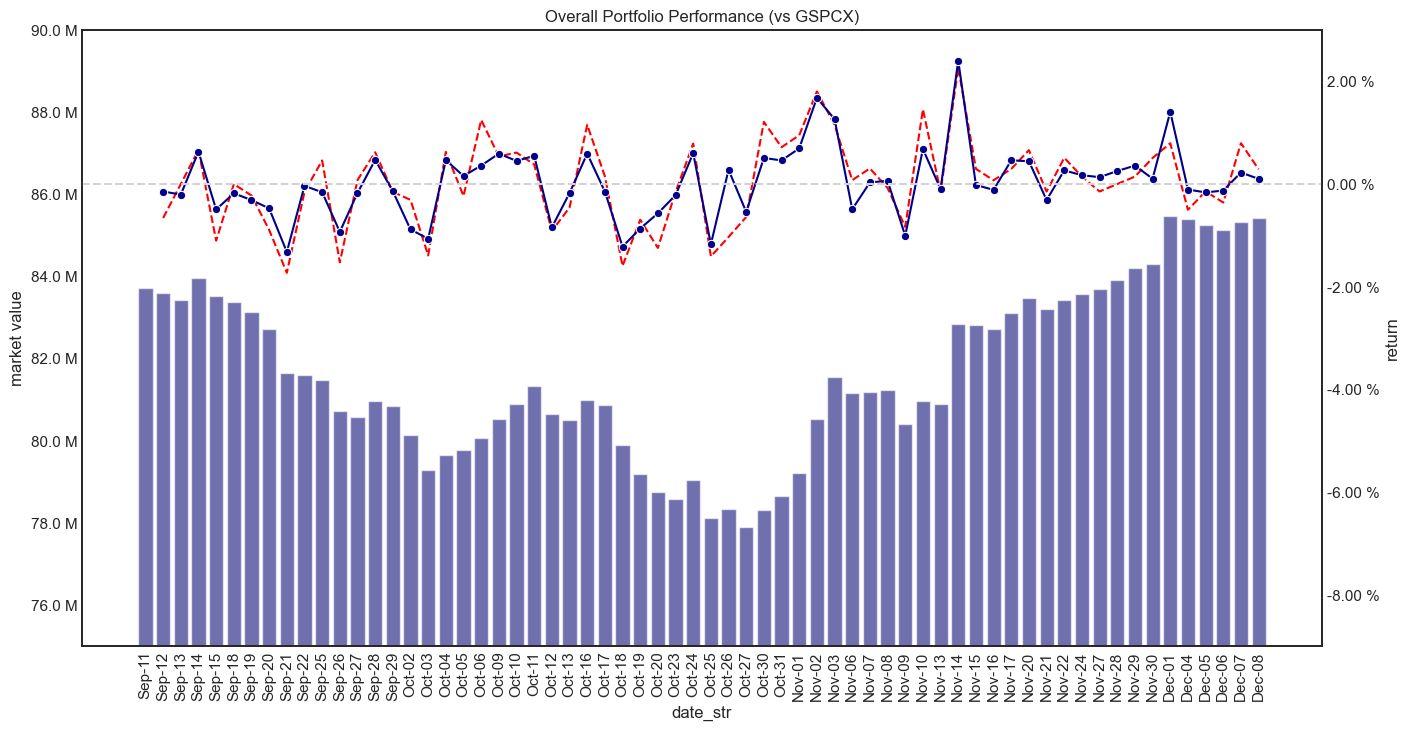

In [230]:
fig, ax1 = plt.subplots(figsize=(16,8))

sns.barplot(data = m1_df, x='date_str', y='Value', alpha=0.60, color='darkblue',  ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(color='red' , linestyle="dashed" ,sort=False, data = m1_df, x='date_str',y ='GSPCX',dashes=True, ax=ax2)
sns.lineplot(color='darkblue' , marker='o' ,sort=False, data = m1_df, x='date_str', y='pct_change',ax=ax2)


ax1.set_ylim(75000000, 90000000)
ax2.set_ylim(-.09, 0.03)

ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['date_str'].tolist()
#ax1.set_xticklabels([pd.to_datetime(tm, unit='w').strftime('%b-%d') for tm in xticks])
ax1.set_yticklabels(['{:,.1f}'.format(y) + ' M' for y in ax1.get_yticks()/1000000])
ax2.set_yticklabels(['{:,.2f}'.format(y) + ' %' for y in ax2.get_yticks()*100])

plt.axhline(y=0, linestyle="dashed", color='lightgray')

# annotations
ax2.set_title('Overall Portfolio Performance (vs GSPCX)')
ax2.set(xlabel='month', ylabel='return')
ax1.set(ylabel='market value')

plt.show()

### Economically Sensitive

In [117]:
t_df = fv_df[fv_df['Class'] == 'Economically Sensitive']
t_df = t_df.merge(benchPercent_econ_df, how='outer', left_on='Date', right_on='Date')
t_df['date_str'] = t_df['Date'].dt.strftime('%b-%d')
t_df.head()

,Date,Class,Value,pct_change,GSPCX,date_str
0,2023-09-11,Economically Sensitive,"50,535,872.6588",NaN,NaN,Sep-11
1,2023-09-12,Economically Sensitive,"50,401,357.6570",-0.0027,-0.0066,Sep-12
2,2023-09-13,Economically Sensitive,"50,201,477.5737",-0.0040,0.0000,Sep-13
3,2023-09-14,Economically Sensitive,"50,758,492.1692",0.0111,0.0067,Sep-14
4,2023-09-15,Economically Sensitive,"50,399,819.5650",-0.0071,-0.0110,Sep-15


In [119]:
r1_df = t_df.loc[(t_df['Date'] == min(t_df['Date']))
                     | (t_df['Date'] == max(t_df['Date']))]
print('Economically Class Return: ',r1_df['Value'].pct_change()[-1:].values)
r1_df

Economically Class Return:  [0.04710813]


,Date,Class,Value,pct_change,GSPCX,date_str
0,2023-09-11,Economically Sensitive,"50,535,872.6588",NaN,NaN,Sep-11
63,2023-12-08,Economically Sensitive,"52,916,523.0738",0.0030,0.0029,Dec-08


In [120]:
r1_df = bench_df.loc[(bench_econ_df.index == min(bench_econ_df.index))
                     | (bench_econ_df.index == max(bench_econ_df.index))]
print('Benchmark Return: ',r1_df['GSPCX'].pct_change()[-1:].values)

Benchmark Return:  [0.02720587]


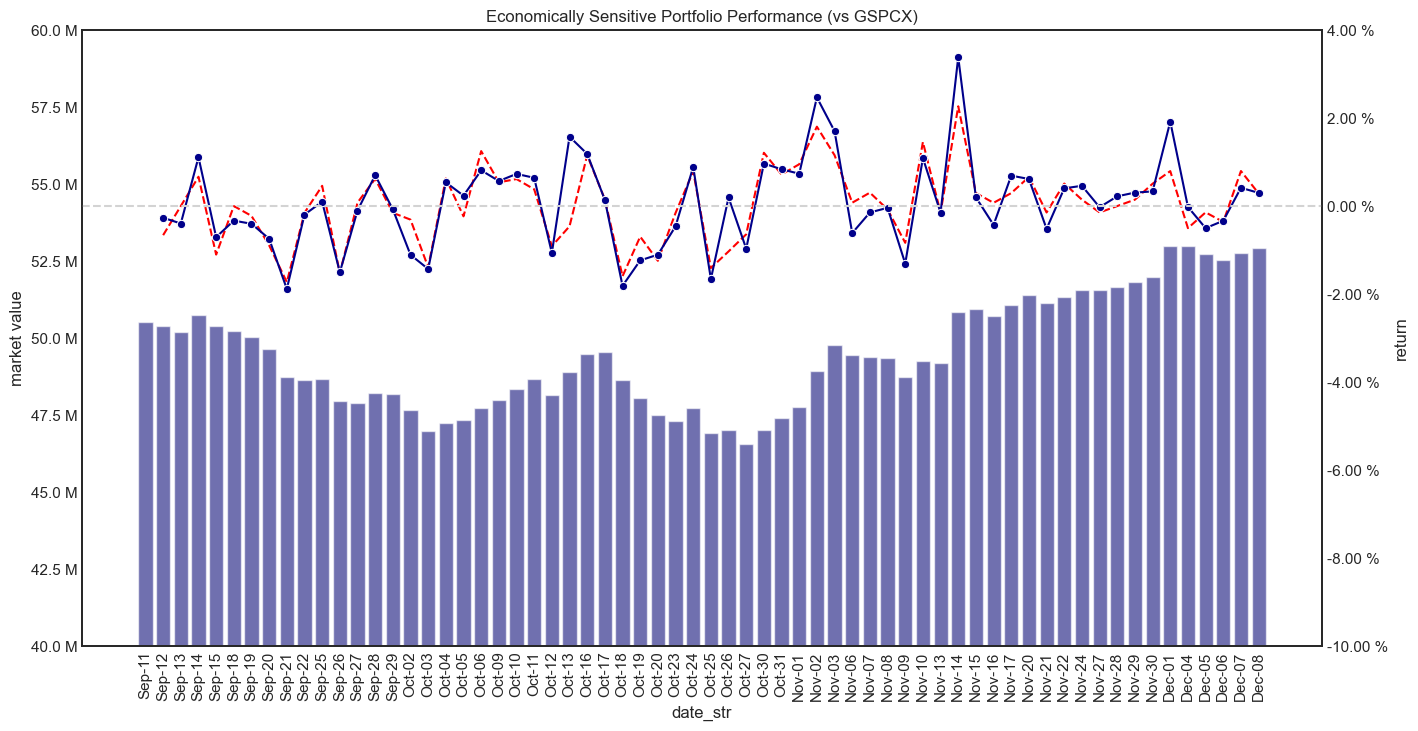

In [125]:
fig, ax1 = plt.subplots(figsize=(16,8))

sns.barplot(data = t_df, x='date_str', y='Value', alpha=0.60, color='darkblue',  ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(color='red' , linestyle="dashed" ,sort=False, data = t_df, x='date_str',y ='GSPCX',dashes=True, ax=ax2)
sns.lineplot(color='darkblue' , marker='o' ,sort=False, data = t_df, x='date_str', y='pct_change',ax=ax2)


ax1.set_ylim(40000000, 60000000)
ax2.set_ylim(-.1, 0.04)

ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = t_df['date_str'].tolist()
#ax1.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])
ax1.set_yticklabels(['{:,.1f}'.format(y) + ' M' for y in ax1.get_yticks()/1000000])
ax2.set_yticklabels(['{:,.2f}'.format(y) + ' %' for y in ax2.get_yticks()*100])

plt.axhline(y=0, linestyle="dashed", color='lightgray')

# annotations
ax2.set_title('Economically Sensitive Portfolio Performance (vs GSPCX)')
ax2.set(xlabel='month', ylabel='return')
ax1.set(ylabel='market value')

plt.show()

### Interest Sensitive

In [126]:
t_df = fv_df[fv_df['Class'] == 'Interest Rate Sensitive']
t_df = t_df.merge(benchPercent_int_df, how='outer', left_on='Date', right_on='Date')
t_df['date_str'] = t_df['Date'].dt.strftime('%b-%d')
t_df.head()

,Date,Class,Value,pct_change,AGG,date_str
0,2023-09-11,Interest Rate Sensitive,"28,999,954.9171",NaN,NaN,Sep-11
1,2023-09-12,Interest Rate Sensitive,"29,012,991.0141",0.0004,0.0003,Sep-12
2,2023-09-13,Interest Rate Sensitive,"29,041,288.5032",0.0010,0.0015,Sep-13
3,2023-09-14,Interest Rate Sensitive,"29,010,499.2465",-0.0011,-0.0014,Sep-14
4,2023-09-15,Interest Rate Sensitive,"28,953,308.6540",-0.0020,-0.0023,Sep-15


In [127]:
r1_df = t_df.loc[(t_df['Date'] == min(t_df['Date']))
                     | (t_df['Date'] == max(t_df['Date']))]
print('Interest Class Return: ',r1_df['Value'].pct_change()[-1:].values)

Interest Class Return:  [0.01106381]


In [128]:
r1_df = bench_int_df.loc[(bench_int_df.index == min(bench_int_df.index))
                     | (bench_int_df.index == max(bench_int_df.index))]
print('Benchmark Return: ',r1_df['AGG'].pct_change()[-1:].values)

Benchmark Return:  [0.01275218]


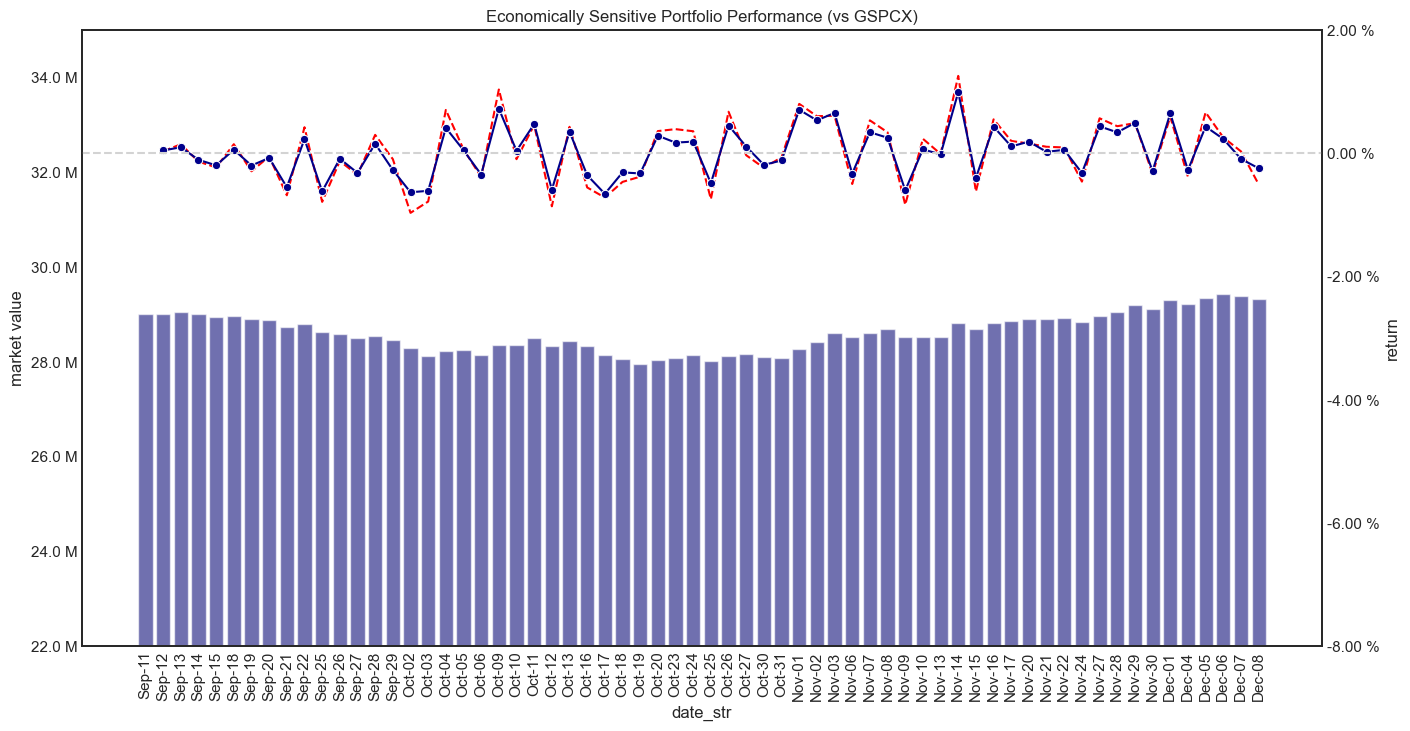

In [129]:
fig, ax1 = plt.subplots(figsize=(16,8))

sns.barplot(data = t_df, x='date_str', y='Value', alpha=0.60, color='darkblue',  ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(color='red' , linestyle="dashed" ,sort=False, data = t_df, x='date_str',y ='AGG',dashes=True, ax=ax2)
sns.lineplot(color='darkblue' , marker='o' ,sort=False, data = t_df, x='date_str', y='pct_change',ax=ax2)


ax1.set_ylim(22000000, 35000000)
ax2.set_ylim(-.08, 0.02)

ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = t_df['date_str'].tolist()
#ax1.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])
ax1.set_yticklabels(['{:,.1f}'.format(y) + ' M' for y in ax1.get_yticks()/1000000])
ax2.set_yticklabels(['{:,.2f}'.format(y) + ' %' for y in ax2.get_yticks()*100])

plt.axhline(y=0, linestyle="dashed", color='lightgray')

# annotations
ax2.set_title('Economically Sensitive Portfolio Performance (vs GSPCX)')
ax2.set(xlabel='month', ylabel='return')
ax1.set(ylabel='market value')

plt.show()

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data = m2_df,x='Date',y='pct_change', color='red' , linestyle="dashed" ,sort=False, ax=ax)
sns.lineplot(data = t_df,x='Date',y='pct_change', marker='o' ,color='darkblue',sort=True, ax=ax)
plt.show()

t_df[['Date','pct_change']]

fig, ax1 = plt.subplots(figsize=(16,8))
ax2 = ax1.twinx()

#sns.lineplot(data = t_df[['Date','pct_change']], marker='o' ,color='darkblue',sort=False, ax=ax1)
sns.lineplot(data = t_df, x='Date', y='pct_change', marker='o' ,color='darkblue',sort=True, ax=ax1)
#sns.lineplot(data = m2_df['GSPCX'], color='red' , linestyle="dashed" ,sort=False, ax=ax1)
sns.lineplot(data = m2_df,x='Date',y='pct_change', color='red' , linestyle="dashed" ,sort=True, ax=ax1)
plt.axhline(y=0, linestyle="dashed", color='lightgray')


#sns.barplot(data = m1_df, x='Date', y='share_value', alpha=0.5, ax=ax2, color='darkblue', width=.5)
sns.barplot(data = t_df, x='Date', y='share_value',errorbar=None,alpha=0.5, ax=ax2, color='darkblue', width=.5)

ax1.set_ylim(-.15, 0.05)
ax2.set_ylim(40000000, 60000000)

fig.autofmt_xdate()
ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['Date'].tolist()
ax2.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])


ax1.set_title('Economically Sensitive Portfolio Performance (vs GSPCX)')
ax1.set(xlabel='month', ylabel='enrollment %')
ax2.set(ylabel='enrollment #')

plt.show()

In [130]:
t_df = fv_df[fv_df['Class'] == 'Interest Rate Sensitive']
t_df = fv_df.merge(benchPercent_int_df, how='outer', left_on='Date', right_on='Date')
t_df.head()

,Date,Class,Value,pct_change,AGG
0,2023-09-11,Cash,"4,182,856.0000",NaN,NaN
1,2023-09-11,Economically Sensitive,"50,535,872.6588",NaN,NaN
2,2023-09-11,Interest Rate Sensitive,"28,999,954.9171",NaN,NaN
3,2023-09-12,Cash,"4,182,856.0000",0.0000,0.0003
4,2023-09-12,Economically Sensitive,"50,401,357.6570",-0.0027,0.0003


fig, ax1 = plt.subplots(figsize=(16,8))
sns.lineplot(data = t_df['pct_change'], marker='o' ,color='darkblue',sort=False, ax=ax1)
sns.lineplot(data = benchPercent_int_df['AGG'], color='red' , linestyle="dashed" ,sort=False, ax=ax1)
plt.axhline(y=0, linestyle="dashed", color='lightgray')

ax2 = ax1.twinx()
#sns.barplot(data = m1_df, x='Date', y='share_value', alpha=0.5, ax=ax2, color='darkblue', width=.5)
sns.barplot(data = t_df, x='Date', y='share_value',errorbar=None,alpha=0.5, ax=ax2, color='darkblue', width=.5)

ax1.set_ylim(-.08, 0.02)
ax2.set_ylim(28000000, 30000000)

fig.autofmt_xdate()
ax1.tick_params(axis='x', labelrotation=90) 
xticks = xticks = m1_df['Date'].tolist()
ax2.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%b-%d') for tm in xticks])

# annotations
ax1.set_title('Interest Rate Sensitive Portfolio Performance (vs AGG)')
ax1.set(xlabel='month', ylabel='enrollment %')
ax2.set(ylabel='enrollment #')

plt.show()

# Alpha Calculations

# Economically Sensitive

In [131]:
#tickers='^DJA'
#tickers = 'FHNFX'
tickers='GSPCX'
bench_data = pdr.get_data_yahoo(tickers=tickers, start=purchase_date, end=end_date )
bench_econ_df= pd.DataFrame(bench_data['Close'])
bench_econ_df.columns = ['bench']
bench_econ_df['precent_bench']= bench_econ_df['bench'].pct_change(1)

print('bench_econ_df:', bench_econ_df.shape)

[*********************100%%**********************]  1 of 1 completed
bench_econ_df: (64, 2)


In [139]:
# ticker symbols
ticker_lst = folio_econ_df['Ticker'].tolist()
print('econ ticker_lst:', len(ticker_lst))

# portfolio weights
weight_lst = (weight_df['port_percent'].values)
print('weight_lst #:', len(weight_lst))

#Download closing prices
price_df = pdr.get_data_yahoo(tickers=ticker_lst, start=purchase_date, end=end_date)['Close']
#price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

econ ticker_lst: 25
weight_lst #: 40
[*********************100%%**********************]  25 of 25 completed
price_df #: (64, 25)


# Shares
#shares_df = folio_df[['Ticker','Shares']]
shares_df = weight_df[['Ticker','Shares']]
#shares_df.set_index('Ticker', drop=True, inplace=True)
print('shares_df: ',shares_df.shape)

# Prices
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
print('m_df: ',m_df.shape)

# Asset Class
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)

m1_df = m_df.merge(l_df, how='left', left_on='Ticker', right_on='Ticker').merge(shares_df,how='outer' ,left_on='Ticker', right_on='Ticker')
m1_df['share_value'] = m1_df['Price'] * m1_df['Shares']
m1_df['pct_share_value'] = m1_df.groupby(['Ticker'])[['share_value']].pct_change()

print('m1_df: ',m1_df.shape)

In [146]:
bench_econ_df

,bench,precent_bench
Date,,
2023-09-11,13.6000,NaN
2023-09-12,13.5100,-0.0066
2023-09-13,13.5100,0.0000
2023-09-14,13.6000,0.0067
2023-09-15,13.4500,-0.0110
...,...,...
2023-12-04,13.8900,-0.0050
2023-12-05,13.8700,-0.0014
2023-12-06,13.8200,-0.0036


In [150]:
bench_econ_df

,bench,precent_bench
Date,,
2023-09-11,13.6000,NaN
2023-09-12,13.5100,-0.0066
2023-09-13,13.5100,0.0000
2023-09-14,13.6000,0.0067
2023-09-15,13.4500,-0.0110
...,...,...
2023-12-04,13.8900,-0.0050
2023-12-05,13.8700,-0.0014
2023-12-06,13.8200,-0.0036


In [149]:
#bench_econ_df 
#m1_df = weight_df[weight_df['Class'] == 'Economically Sensitive']
m1_df = merge_df[merge_df['Class'] == 'Economically Sensitive']
m1_df

,Date,Ticker,Value,Class,Sub_Class,pct_share_value
64,2023-09-11,ARKK,0.0000,Economically Sensitive,U.S. Equities,NaN
65,2023-09-12,ARKK,0.0000,Economically Sensitive,U.S. Equities,NaN
66,2023-09-13,ARKK,0.0000,Economically Sensitive,U.S. Equities,NaN
67,2023-09-14,ARKK,0.0000,Economically Sensitive,U.S. Equities,NaN
68,2023-09-15,ARKK,0.0000,Economically Sensitive,U.S. Equities,NaN
...,...,...,...,...,...,...
2491,2023-12-04,VONG,"3,092,239.5987",Economically Sensitive,U.S. Equities,-0.0086
2492,2023-12-05,VONG,"3,107,594.7660",Economically Sensitive,U.S. Equities,0.0050
2493,2023-12-06,VONG,"3,090,579.5207",Economically Sensitive,U.S. Equities,-0.0055
2494,2023-12-07,VONG,"3,126,270.4060",Economically Sensitive,U.S. Equities,0.0115


In [151]:
alpha_econ_df = pd.DataFrame(columns=['Ticker','alpha','beta'])

for t in ticker_lst:
    X = bench_econ_df['precent_bench'].values
    y = m1_df[m1_df['Ticker'] == t]['pct_share_value'].values
    
    t_df = pd.DataFrame({'X':X,'y':y})
    t_df = t_df[np.isfinite(t_df).all(1)]
    
    alpha, beta = linreg(t_df.X.values,t_df.y.values)
    alpha_econ_df.loc[len(alpha_econ_df.index)] = [t, alpha, beta]
    
print('alpha_econ_df:', alpha_econ_df.shape)
alpha_econ_df.head()

alpha_econ_df: (25, 3)


,Ticker,alpha,beta
0,IVV,-0.0000,0.9740
1,VONG,0.0002,1.1088
2,SCHD,-0.0006,0.8871
3,IMCB,-0.0044,1.4076
4,VO,-0.0002,1.0865


## Graph

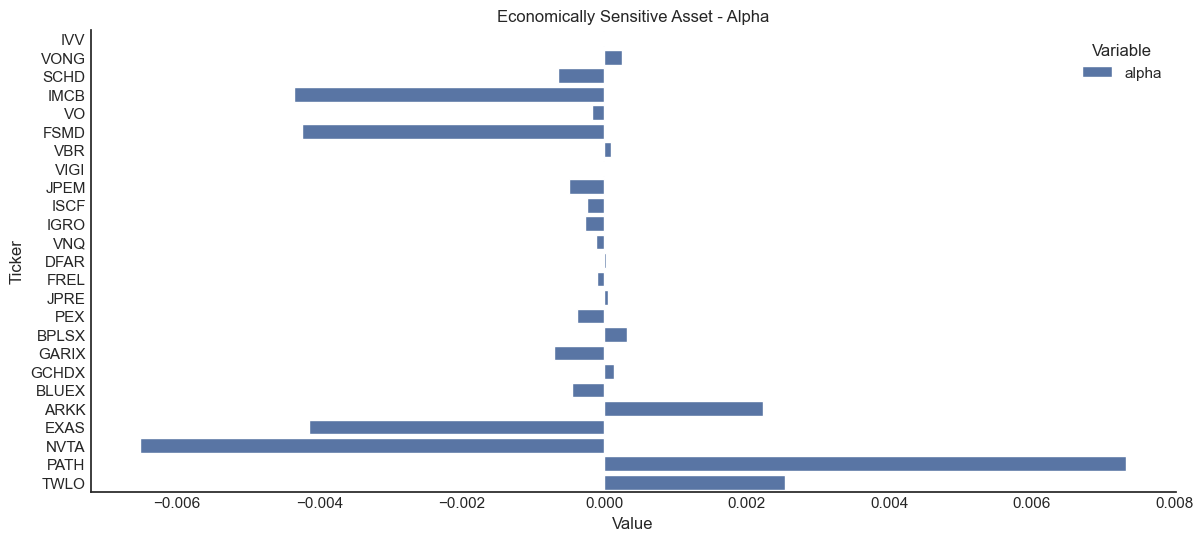

In [158]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_econ_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'alpha']
#t_df = t_df.sort_values(by=['Value'], key=pd.Series.abs , ascending=True ).copy()
g = sns.barplot(x='Value', y='Ticker', hue='Variable',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Economically Sensitive Asset - Alpha');

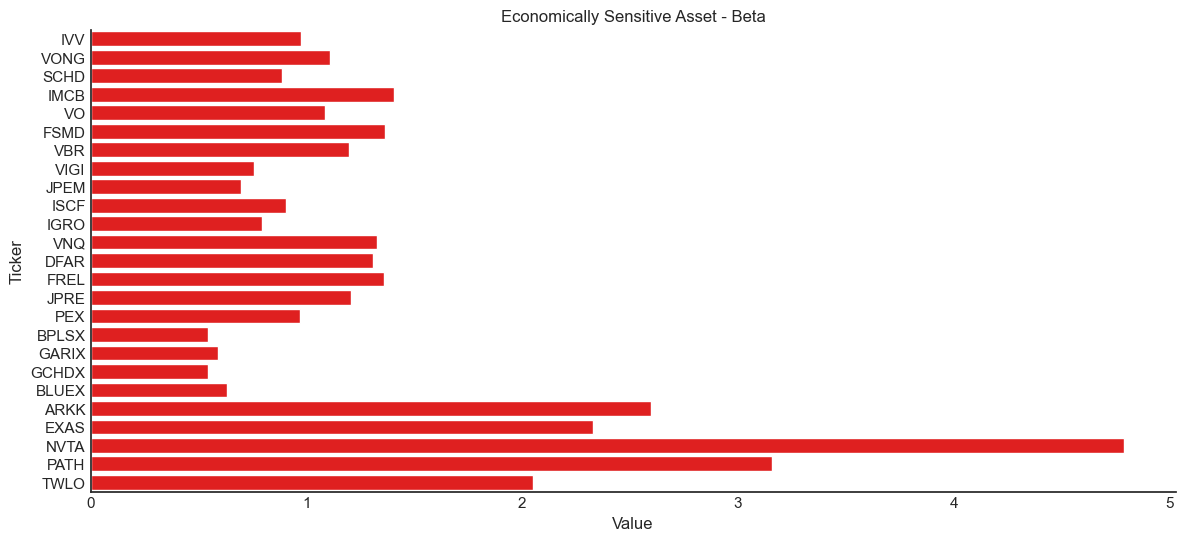

In [157]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_econ_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'beta']
#t_df = t_df.sort_values(by=['Value'], key=pd.Series.abs , ascending=True ).copy()
g = sns.barplot(x='Value', y='Ticker', color='red', data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Economically Sensitive Asset - Beta');

# Interest Rate Sensitive

In [163]:
#tickers='^DJA'
#tickers = 'FHNFX'
tickers = 'AGG'
bench_data = pdr.get_data_yahoo(tickers=tickers, start=purchase_date, end=end_date)
bench_int_df= pd.DataFrame(bench_data['Close'])
bench_int_df.columns = ['bench']
bench_int_df['precent_bench']= bench_int_df['bench'].pct_change(1)

print('bench_int_df #:', bench_int_df.shape)
lb = len(bench_int_df)

[*********************100%%**********************]  1 of 1 completed
bench_int_df #: (64, 2)


,Unnamed: 0,Ticker,BondName,Morningstar_Category,Class,Sub_Class,Date,Value
15,15,MMIN,IQ MacKay Municipal Insured ETF,Muni National Long,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,2023-09-11,"1,000.0000"
16,16,MEAR,iShares Short Maturity Municipal Bd ETF,Muni National Short,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,2023-09-11,"1,000.0000"
17,17,MMIT,IQ MacKay Municipal Intermediate ETF,Muni National Interm,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,2023-09-11,"1,000.0000"
18,18,SNDPX,AB Diversified Municipal,Muni National Short,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,2023-09-11,"1,000.0000"
19,19,ALTVX,AB Municipal Income National Advisor,Muni National Interm,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,2023-09-11,"1,000.0000"
20,20,IGMWX,Voya GNMA Income W,Intermediate Government,Interest Rate Sensitive,U.S. Government Bonds,2023-09-11,"5,500.0000"
21,21,VFIUX,Vanguard Interm-Term Treasury Adm,Intermediate Government,Interest Rate Sensitive,U.S. Government Bonds,2023-09-11,"5,500.0000"
22,22,VICSX,Vanguard Interm-Term Corp Bd Idx Admiral,Corporate Bond,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,2023-09-11,"2,000.0000"
23,23,VGCAX,Vanguard Global Credit Bond Admiral,Corporate Bond,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,2023-09-11,"1,000.0000"
24,24,PSAIX,PIMCO Global Advantage Strategy Bd Instl,Global Bond,Interest Rate Sensitive,Very-High-Quality Corporate Bonds,2023-09-11,"1,000.0000"


In [166]:
# ticker symbols
ticker_lst = folio_int_df['Ticker'].tolist()
print('econ ticker_lst:', len(ticker_lst))

# portfolio weights
weight_lst = (weight_df['port_percent'].values)
print('weight_lst #:', len(weight_lst))

#Download closing prices
price_df = pdr.get_data_yahoo(tickers=ticker_lst, start=purchase_date, end=end_date)['Close']
#price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

econ ticker_lst: 14
weight_lst #: 40
[*********************100%%**********************]  14 of 14 completed
price_df #: (64, 14)


# Shares
shares_df = folio_int_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
print('shares_df: ',shares_df.shape)

# Prices
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
print('m_df: ',m_df.shape)

# Asset Class
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)

m1_df = m_df.merge(l_df, how='outer', left_on='Ticker', right_on='Ticker').merge(shares_df,how='outer' ,left_on='Ticker', right_on='Ticker')
m1_df['share_value'] = m1_df['Price'] * m1_df['Shares']
m1_df['pct_share_value'] = m1_df.groupby(['Ticker'])[['share_value']].pct_change()

print('m1_df: ',m1_df.shape)

In [162]:
bench_int_df

,AGG
Date,
2023-09-11,95.6700
2023-09-12,95.7000
2023-09-13,95.8400
2023-09-14,95.7100
2023-09-15,95.4900
...,...
2023-12-04,96.4600
2023-12-05,97.1000
2023-12-06,97.3500


In [160]:
#bench_econ_df 
#m1_df = weight_df[weight_df['Class'] == 'Economically Sensitive']
m1_df = merge_df[merge_df['Class'] == 'Interest Rate Sensitive']
m1_df

,Date,Ticker,Value,Class,Sub_Class,pct_share_value
0,2023-09-11,ALTVX,"1,000,000.1594",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,NaN
1,2023-09-12,ALTVX,"998,936.4065",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,-0.0011
2,2023-09-13,ALTVX,"998,936.4065",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,0.0000
3,2023-09-14,ALTVX,"997,872.5522",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,-0.0011
4,2023-09-15,ALTVX,"997,872.5522",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,0.0000
...,...,...,...,...,...,...
2555,2023-12-04,VTEB,"1,018,886.6424",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,-0.0008
2556,2023-12-05,VTEB,"1,021,326.5807",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,0.0024
2557,2023-12-06,VTEB,"1,022,343.2152",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,0.0010
2558,2023-12-07,VTEB,"1,022,953.2579",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,0.0006


In [167]:
alpha_int_df = pd.DataFrame(columns=['Ticker','alpha','beta'])

for t in ticker_lst:
    X = bench_int_df['precent_bench'].values
    y = m1_df[m1_df['Ticker'] == t]['pct_share_value'].values
    
    t_df = pd.DataFrame({'X':X,'y':y})
    t_df = t_df[np.isfinite(t_df).all(1)]
    
    alpha, beta = linreg(t_df.X.values,t_df.y.values)
    alpha_int_df.loc[len(alpha_int_df.index)] = [t, alpha, beta]
    
print('alpha_int_df:', alpha_int_df.shape)
alpha_int_df.head()

alpha_int_df: (14, 3)


,Ticker,alpha,beta
0,MMIN,0.0002,0.7434
1,MEAR,0.0000,0.0079
2,MMIT,0.0002,0.4111
3,SNDPX,0.0002,0.2256
4,ALTVX,0.0002,0.4338


## Graph

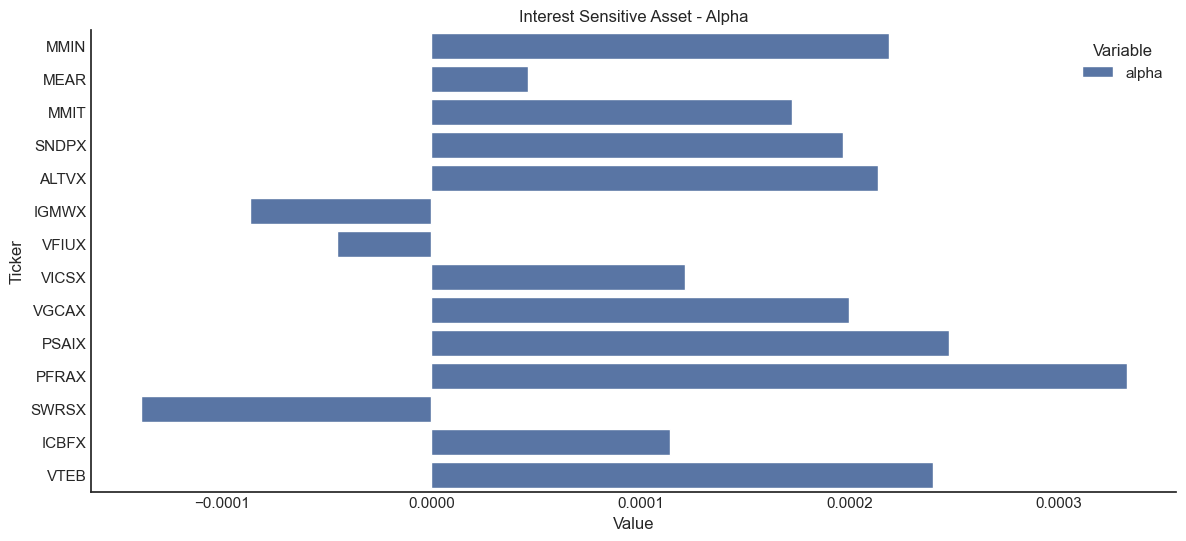

In [168]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_int_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'alpha']
g = sns.barplot(x='Value', y='Ticker', hue='Variable',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Interest Sensitive Asset - Alpha');

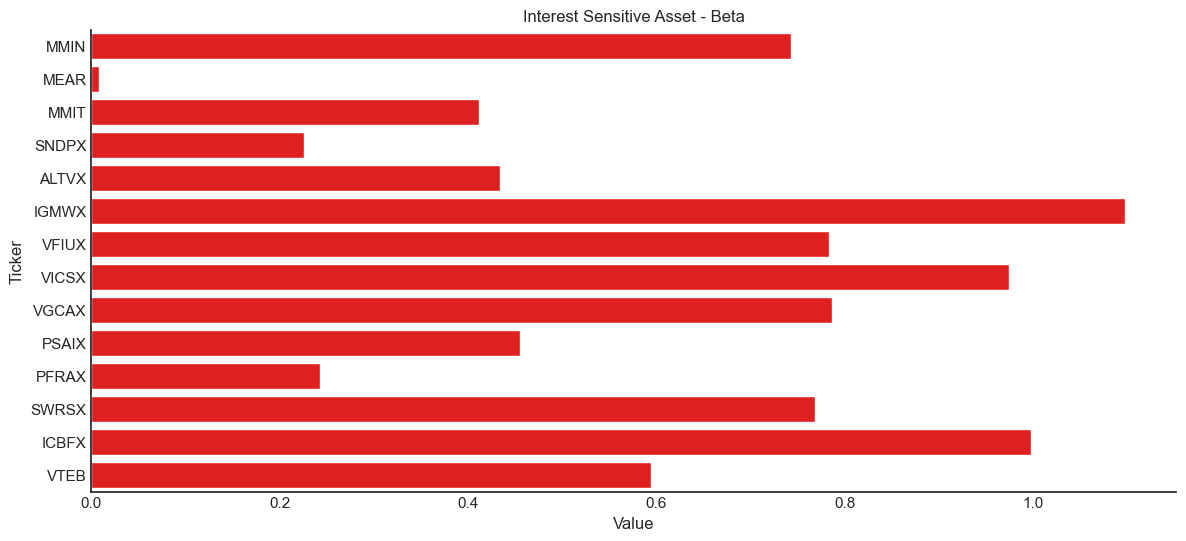

In [169]:
fig, ax = plt.subplots(figsize=(14,6))
t_df = alpha_int_df.melt(id_vars='Ticker').rename(columns=str.title)
t_df = t_df[t_df['Variable'] == 'beta']
g = sns.barplot(x='Value', y='Ticker', color='red',data=t_df, ax=ax)
sns.despine(fig)
ax.set(title='Interest Sensitive Asset - Beta');

# Performance

In [170]:
f_df = merge_df.loc[(merge_df['Date'] == min(merge_df['Date']))
                     | (merge_df['Date'] == max(merge_df['Date']))]
f_df['pct_share_value'] = merge_df.groupby(['Ticker'])[['Value']].pct_change()
f_df = f_df.loc[(f_df['Date'] == max(f_df['Date']))]

print('f_df: ', f_df.shape)
f_df.head()

f_df:  (40, 6)


,Date,Ticker,Value,Class,Sub_Class,pct_share_value
63,2023-12-08,ALTVX,"1,019,149.1319",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,-0.0010
127,2023-12-08,ARKK,"1,302,089.6881",Economically Sensitive,U.S. Equities,0.0184
191,2023-12-08,BLUEX,"494,194.7892",Economically Sensitive,Long/Short Equities,-0.0006
255,2023-12-08,BPLSX,"776,487.1781",Economically Sensitive,Long/Short Equities,0.0032
319,2023-12-08,C_A_S_H,"3,182,856.0000",Cash,Cash,0.0000


In [171]:
a_df = pd.concat([alpha_econ_df,alpha_int_df])
a_df.head()

,Ticker,alpha,beta
0,IVV,-0.0000,0.9740
1,VONG,0.0002,1.1088
2,SCHD,-0.0006,0.8871
3,IMCB,-0.0044,1.4076
4,VO,-0.0002,1.0865


In [172]:
f1_df = f_df.merge(a_df, how='left', left_on='Ticker', right_on='Ticker') 
f1_df.fillna(0, inplace=True)
f1_df.head()

,Date,Ticker,Value,Class,Sub_Class,pct_share_value,alpha,beta
0,2023-12-08,ALTVX,"1,019,149.1319",Interest Rate Sensitive,Very-High-Quality Municipal Bonds,-0.0010,0.0002,0.4338
1,2023-12-08,ARKK,"1,302,089.6881",Economically Sensitive,U.S. Equities,0.0184,0.0022,2.5986
2,2023-12-08,BLUEX,"494,194.7892",Economically Sensitive,Long/Short Equities,-0.0006,-0.0005,0.6315
3,2023-12-08,BPLSX,"776,487.1781",Economically Sensitive,Long/Short Equities,0.0032,0.0003,0.5453
4,2023-12-08,C_A_S_H,"3,182,856.0000",Cash,Cash,0.0000,0.0000,0.0000


In [173]:
long_df = f1_df[['Date','Ticker','Class','Sub_Class','pct_share_value','alpha','beta']].copy()
long_df= long_df[long_df['Class'] == 'Economically Sensitive']

long_df.reset_index(inplace=True, drop=True)
long_df = long_df.melt(id_vars=['Date','Ticker','Class','Sub_Class'])
long_df.head()

,Date,Ticker,Class,Sub_Class,variable,value
0,2023-12-08,ARKK,Economically Sensitive,U.S. Equities,pct_share_value,0.0184
1,2023-12-08,BLUEX,Economically Sensitive,Long/Short Equities,pct_share_value,-0.0006
2,2023-12-08,BPLSX,Economically Sensitive,Long/Short Equities,pct_share_value,0.0032
3,2023-12-08,DFAR,Economically Sensitive,Publicly Traded REITs,pct_share_value,-0.0018
4,2023-12-08,EXAS,Economically Sensitive,U.S. Equities,pct_share_value,-0.0037


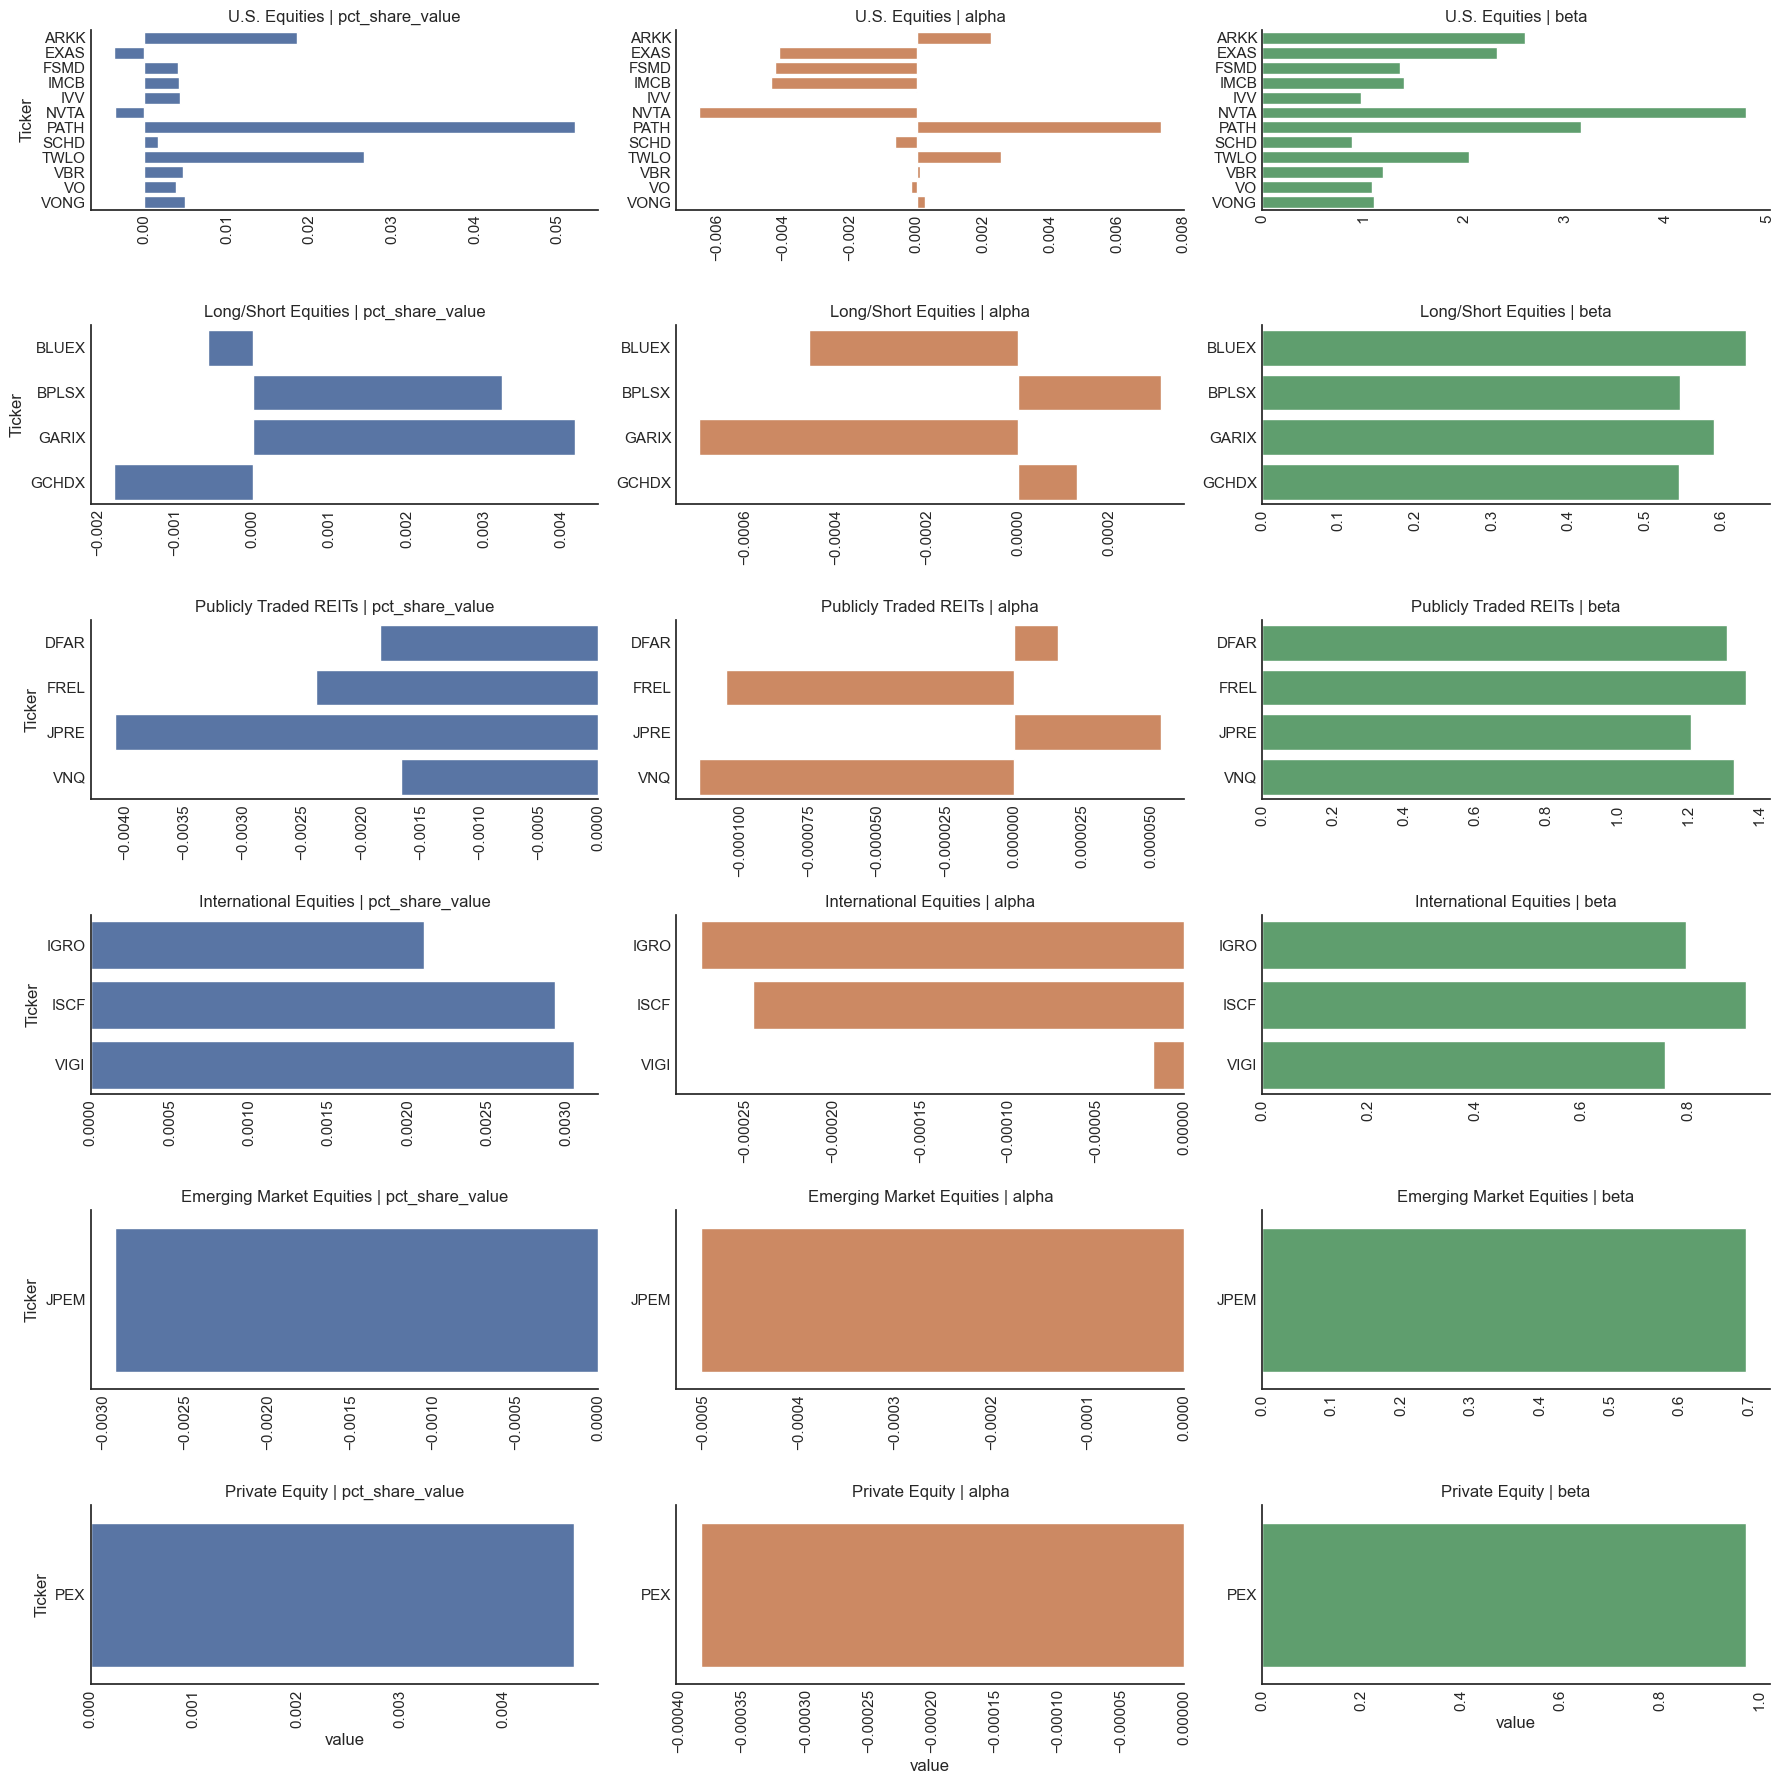

In [174]:
# Graph
g = sns.FacetGrid(long_df, col='variable', row = 'Sub_Class', hue='variable',
                  height=3, aspect=2, sharex=False, sharey=False)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.tick_params(axis='x', labelrotation=90) 
g.tight_layout()
g.map_dataframe(sns.barplot, y="Ticker", x="value")

plt.show()

# Monte Carlo

In [179]:
mc_sims = 50 
mc_bust = -.4
mc_goal = 1

In [178]:
totalValue_df[1:]['pct_change']

1    -0.0015
2    -0.0021
3     0.0063
4    -0.0050
5    -0.0018
       ...  
59   -0.0011
60   -0.0016
61   -0.0013
62    0.0022
63    0.0010
Name: pct_change, Length: 63, dtype: float64

In [183]:
mc.data

,original,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.0015,0.0006,-0.0049,0.0127,-0.0084,-0.0057,-0.0050,-0.0013,0.0051,0.0010,...,0.0036,0.0241,-0.0031,-0.0088,-0.0018,0.0059,-0.0093,0.0047,-0.0031,0.0059
1,-0.0021,0.0046,-0.0031,-0.0049,-0.0010,0.0016,0.0047,-0.0002,-0.0050,-0.0011,...,-0.0132,0.0046,0.0010,-0.0014,-0.0016,-0.0049,-0.0021,0.0068,0.0047,0.0017
2,0.0063,-0.0018,-0.0016,0.0025,-0.0018,-0.0050,-0.0010,0.0022,0.0047,0.0044,...,-0.0050,-0.0016,0.0068,0.0013,-0.0016,0.0055,-0.0022,-0.0016,0.0013,0.0060
3,-0.0050,0.0051,0.0059,-0.0015,0.0046,-0.0054,0.0059,-0.0011,0.0036,-0.0087,...,-0.0088,0.0047,-0.0087,-0.0013,0.0016,-0.0010,-0.0050,-0.0022,-0.0088,0.0070
4,-0.0018,-0.0021,-0.0132,0.0010,0.0010,-0.0014,-0.0087,0.0168,-0.0031,-0.0101,...,0.0016,-0.0088,-0.0101,-0.0132,-0.0093,-0.0057,-0.0047,-0.0054,0.0127,-0.0101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,-0.0011,0.0010,0.0046,-0.0018,-0.0047,0.0045,-0.0049,0.0010,-0.0093,0.0046,...,-0.0010,0.0168,-0.0016,0.0047,-0.0011,-0.0101,0.0241,0.0141,-0.0021,0.0068
59,-0.0016,-0.0011,-0.0088,-0.0021,0.0168,0.0017,0.0036,-0.0088,0.0060,-0.0010,...,0.0046,-0.0049,-0.0049,0.0044,0.0141,0.0046,0.0063,-0.0057,0.0025,-0.0015
60,-0.0013,0.0063,0.0036,-0.0011,0.0022,0.0022,0.0025,-0.0004,-0.0088,0.0046,...,-0.0017,-0.0016,-0.0047,-0.0057,0.0046,0.0003,0.0036,0.0045,0.0017,-0.0018
61,0.0022,-0.0016,0.0051,-0.0132,-0.0117,-0.0107,-0.0021,0.0046,0.0059,-0.0107,...,-0.0093,-0.0087,0.0127,0.0036,0.0010,0.0010,0.0046,0.0059,-0.0015,0.0168


mc.data: (63, 50)


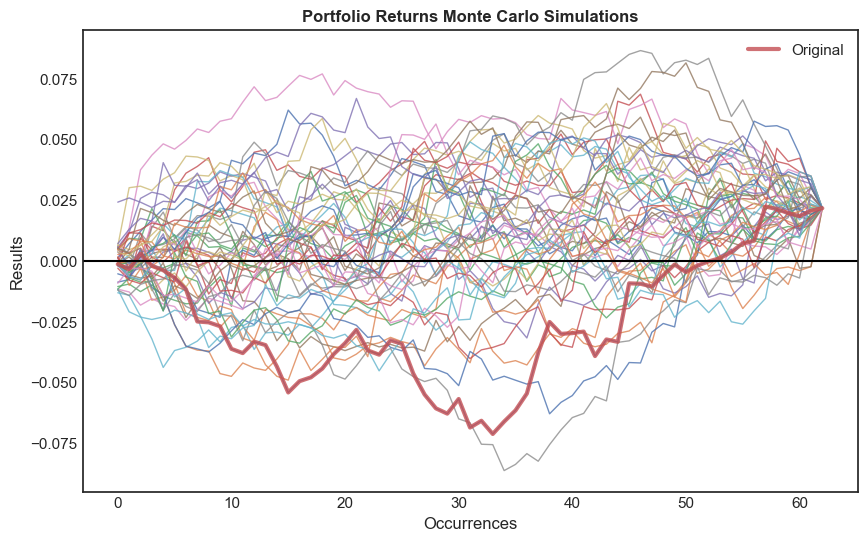

In [231]:
mc = totalValue_df[1:]['pct_change'].montecarlo(sims=mc_sims, bust=mc_bust, goal=mc_goal)
print('mc.data:', mc.data.shape)
mc.plot(title="Portfolio Returns Monte Carlo Simulations")  # optional: , figsize=(x, y)

In [197]:
mc.stats

{'min': 0.021555567423053645,
 'max': 0.021555567423053645,
 'mean': 0.021555567423053645,
 'median': 0.021555567423053645,
 'std': 0.0,
 'maxdd': -0.0712988265445138,
 'bust': 0.0,
 'goal': 0.0}

In [234]:
# Perform Monte Carlo simulation on the returns
simulated_data = pd.DataFrame.pandas_montecarlo(totalValue_df[1:], n=mc_sims, forecast_period=252, method='historical')

# Plot the simulations
register_matplotlib_converters()
plt.figure(figsize=(10, 6))
plt.title('Monte Carlo Simulations of Stock Returns')
plt.plot(simulated_data, color='gray', alpha=0.2)
plt.xlabel('Time')
plt.ylabel('Returns')
plt.show()

# Summary statistics of the simulated data
summary_statistics = simulated_data.describe()
print(summary_statistics)

AttributeError: type object 'DataFrame' has no attribute 'pandas_montecarlo'

In [188]:
df = mc.data.copy()
df.index = totalValue_df[1:].Date
df

,original,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-12,-0.0015,0.0006,-0.0049,0.0127,-0.0084,-0.0057,-0.0050,-0.0013,0.0051,0.0010,...,0.0036,0.0241,-0.0031,-0.0088,-0.0018,0.0059,-0.0093,0.0047,-0.0031,0.0059
2023-09-13,-0.0021,0.0046,-0.0031,-0.0049,-0.0010,0.0016,0.0047,-0.0002,-0.0050,-0.0011,...,-0.0132,0.0046,0.0010,-0.0014,-0.0016,-0.0049,-0.0021,0.0068,0.0047,0.0017
2023-09-14,0.0063,-0.0018,-0.0016,0.0025,-0.0018,-0.0050,-0.0010,0.0022,0.0047,0.0044,...,-0.0050,-0.0016,0.0068,0.0013,-0.0016,0.0055,-0.0022,-0.0016,0.0013,0.0060
2023-09-15,-0.0050,0.0051,0.0059,-0.0015,0.0046,-0.0054,0.0059,-0.0011,0.0036,-0.0087,...,-0.0088,0.0047,-0.0087,-0.0013,0.0016,-0.0010,-0.0050,-0.0022,-0.0088,0.0070
2023-09-18,-0.0018,-0.0021,-0.0132,0.0010,0.0010,-0.0014,-0.0087,0.0168,-0.0031,-0.0101,...,0.0016,-0.0088,-0.0101,-0.0132,-0.0093,-0.0057,-0.0047,-0.0054,0.0127,-0.0101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,-0.0011,0.0010,0.0046,-0.0018,-0.0047,0.0045,-0.0049,0.0010,-0.0093,0.0046,...,-0.0010,0.0168,-0.0016,0.0047,-0.0011,-0.0101,0.0241,0.0141,-0.0021,0.0068
2023-12-05,-0.0016,-0.0011,-0.0088,-0.0021,0.0168,0.0017,0.0036,-0.0088,0.0060,-0.0010,...,0.0046,-0.0049,-0.0049,0.0044,0.0141,0.0046,0.0063,-0.0057,0.0025,-0.0015
2023-12-06,-0.0013,0.0063,0.0036,-0.0011,0.0022,0.0022,0.0025,-0.0004,-0.0088,0.0046,...,-0.0017,-0.0016,-0.0047,-0.0057,0.0046,0.0003,0.0036,0.0045,0.0017,-0.0018


RangeIndex(start=1, stop=64, step=1)

In [191]:
long_df = df.drop(columns=['original']).copy()
long_df

,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,49
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-12,0.0006,-0.0049,0.0127,-0.0084,-0.0057,-0.0050,-0.0013,0.0051,0.0010,-0.0088,...,0.0036,0.0241,-0.0031,-0.0088,-0.0018,0.0059,-0.0093,0.0047,-0.0031,0.0059
2023-09-13,0.0046,-0.0031,-0.0049,-0.0010,0.0016,0.0047,-0.0002,-0.0050,-0.0011,-0.0015,...,-0.0132,0.0046,0.0010,-0.0014,-0.0016,-0.0049,-0.0021,0.0068,0.0047,0.0017
2023-09-14,-0.0018,-0.0016,0.0025,-0.0018,-0.0050,-0.0010,0.0022,0.0047,0.0044,-0.0087,...,-0.0050,-0.0016,0.0068,0.0013,-0.0016,0.0055,-0.0022,-0.0016,0.0013,0.0060
2023-09-15,0.0051,0.0059,-0.0015,0.0046,-0.0054,0.0059,-0.0011,0.0036,-0.0087,0.0046,...,-0.0088,0.0047,-0.0087,-0.0013,0.0016,-0.0010,-0.0050,-0.0022,-0.0088,0.0070
2023-09-18,-0.0021,-0.0132,0.0010,0.0010,-0.0014,-0.0087,0.0168,-0.0031,-0.0101,-0.0122,...,0.0016,-0.0088,-0.0101,-0.0132,-0.0093,-0.0057,-0.0047,-0.0054,0.0127,-0.0101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,0.0010,0.0046,-0.0018,-0.0047,0.0045,-0.0049,0.0010,-0.0093,0.0046,0.0028,...,-0.0010,0.0168,-0.0016,0.0047,-0.0011,-0.0101,0.0241,0.0141,-0.0021,0.0068
2023-12-05,-0.0011,-0.0088,-0.0021,0.0168,0.0017,0.0036,-0.0088,0.0060,-0.0010,0.0047,...,0.0046,-0.0049,-0.0049,0.0044,0.0141,0.0046,0.0063,-0.0057,0.0025,-0.0015
2023-12-06,0.0063,0.0036,-0.0011,0.0022,0.0022,0.0025,-0.0004,-0.0088,0.0046,0.0045,...,-0.0017,-0.0016,-0.0047,-0.0057,0.0046,0.0003,0.0036,0.0045,0.0017,-0.0018


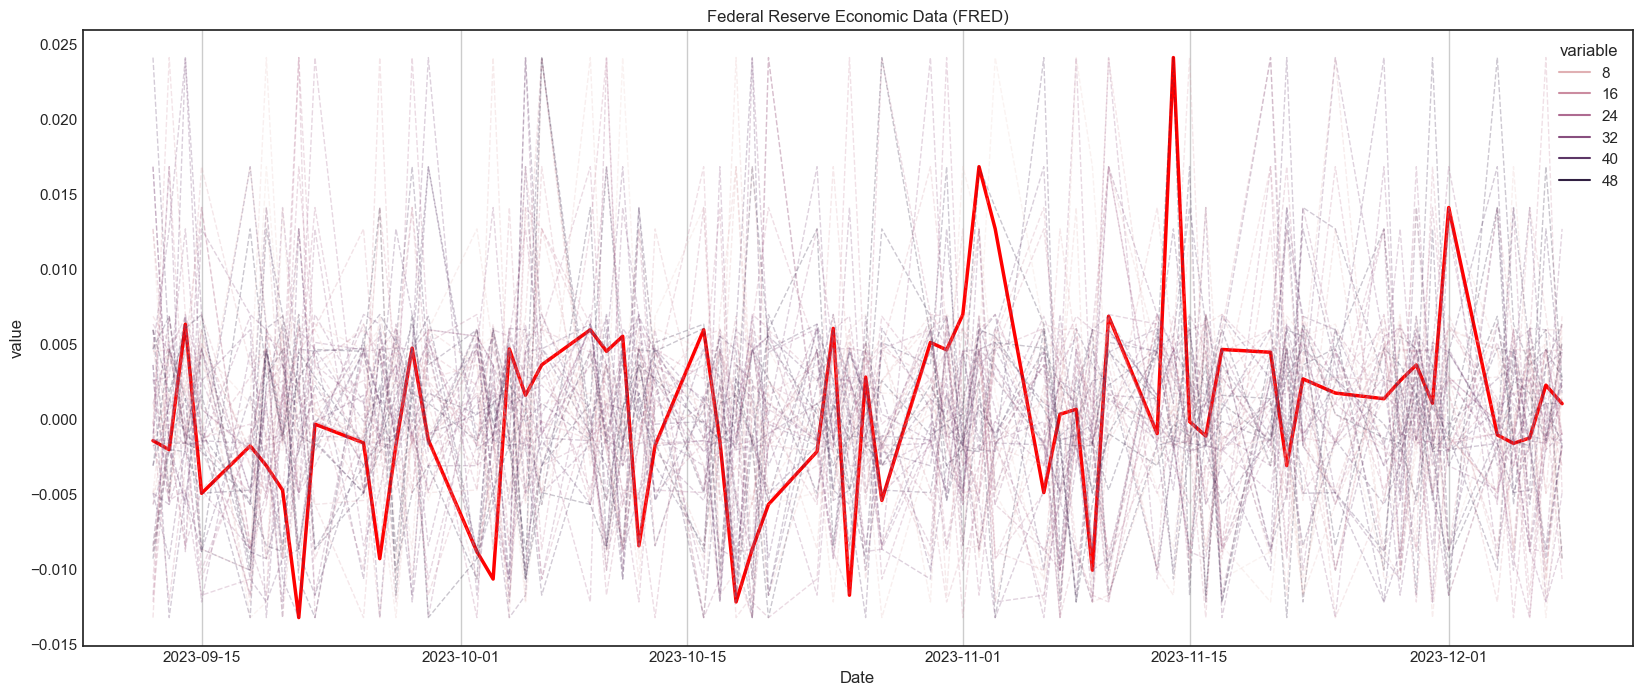

In [196]:
# Long 
long_df = df.drop(columns=['original']).copy()
long_df.reset_index(inplace=True)
long_df = long_df.melt(id_vars=['Date'])


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(df.index, df['original'], 'red', linewidth=2.5)
#ax.plot(taylor_df.index, taylor_df['UNRATE'], 'blue', linewidth=2)

sns.lineplot(x = 'Date', y = 'value', data=long_df, hue='variable', linestyle='--',linewidth=1, alpha=0.25)

#ax.legend(["FEDFUNDS","gap_inf"])
ax.set(title='Federal Reserve Economic Data (FRED)');
plt.show()